In [802]:
%reload_ext autoreload

In [803]:
# Imports

%load_ext autoreload
%autoreload 2

%matplotlib inline
import numpy as np
import random
from fastai.imports import *
from fastai.structured import *
from matplotlib import pyplot
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from tabulate import tabulate
from sklearn.model_selection import GridSearchCV
from scipy.stats import trim_mean, kurtosis
from scipy.stats.mstats import mode, gmean, hmean
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.metrics import f1_score,\
    accuracy_score, confusion_matrix,\
    precision_score, recall_score,\
    roc_curve, roc_auc_score,\
    cohen_kappa_score, mean_absolute_error,\
    precision_recall_curve, auc,\
    average_precision_score

set_plot_sizes(12,14,16)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [804]:
# Constants
PROBABILITY_CUTOFF = 0.50

# Utility functions
def plot_roc_pr(m, X_valid, y_valid):
    # Generate the probabilities
    #y_pred_prob = generate_predictions(X_valid)
    y_pred_prob = m.predict_proba(X_valid)
    y_pred_prob = y_pred_prob[:, 1]

    # Calculate the roc metrics
    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_prob)

    fig, ax = plt.subplots(figsize=(20,10))

    # Plot the ROC curve
    plt.plot(fpr,tpr, label='ROC')

    # Add labels and diagonal line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.plot([0, 1], [0, 1], "k--", label='no skill')

    # Plot a precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_valid, y_pred_prob)
    area_under_curve = auc(recall, precision)
    ap = average_precision_score(y_valid, y_pred_prob)

    # plot no skill
    pyplot.plot([0, 1], [0.5, 0.5], linestyle='--', label='no skill')
    # plot the precision-recall curve for the model
    pyplot.plot(recall, precision, marker='.', label='precision-recall')

    legend = ax.legend(loc='best', shadow=True, fontsize='medium')

    # show the plot
    pyplot.show()
    
    # Output AUC and average precision score
    print('auc=%.3f ap=%.3f' % (area_under_curve, ap))
    
def uber_score(y_valid, validate_predictions):
    return [precision_score(y_valid,validate_predictions), recall_score(y_valid,validate_predictions), f1_score(y_valid,validate_predictions), accuracy_score(y_valid,validate_predictions), cohen_kappa_score(y_valid,validate_predictions), mean_absolute_error(y_valid,validate_predictions)]

def graph_corr(df):
    fig, ax = plt.subplots(figsize=(20,10))
    corr = df.corr()
    sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
    ax.set_title("Correlation Matrix", fontsize=14)
    plt.show()
    
def data_summary(df_raw):
    array = []
    for column_name in df_raw.select_dtypes(include=['float64', 'int64']).columns:
        mean = df_raw[column_name].mean()
        median = df_raw[column_name].median()
        std = df_raw[column_name].std()
        cv = df_raw[column_name].std()/df_raw[column_name].mean()
        trimmed_mean = trim_mean(df_raw[column_name].values, 0.1)
        array.append([column_name, mean, median, std, cv, trimmed_mean])
    print(tabulate(array,headers=['Column', 'Mean', 'Median', 'Std', 'cv', 'Trimmed Mean']))

def generate_predictions(X_valid, cutoff=PROBABILITY_CUTOFF):
    return m.predict(X_valid)
    #return (m.predict_proba(X_valid)[:,1] >= cutoff).astype(bool)
    
def conf_matrix(y_valid, validate_predictions):
    cm = confusion_matrix(y_valid, validate_predictions)
    print(cm)
    
def remove_columns_test(df):
    m = RandomForestClassifier(
        n_estimators=10,
        min_samples_leaf=1, 
        max_features='sqrt',
        n_jobs=-1, 
        #oob_score=True,
        max_depth=3,
        bootstrap=False,
        criterion='gini',
        class_weight={0: 2, 1: 1})
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    y_pred = m.predict(x)
    return uber_score(y_train, y_pred)

In [805]:
# Load in data

PATH = "../../data/"
df_raw = pd.read_csv(f'{PATH}churn.csv', low_memory=False, 
                     parse_dates=['canceldate', 'licence_registration_date', 'golive_date'])

In [806]:
#df_raw = df_raw.sort('licence_registration_date')
df_raw = df_raw.sort_values(by='licence_registration_date')

#df_raw.licence_registration_date.head(5), df_raw.licence_registration_date.tail(5)

In [807]:
# Convert annual_revenue from a string to a float

df_raw['annual_revenue'] = pd.to_numeric(df_raw['annual_revenue'].str.replace(',', ''))

In [808]:
# Output the count for churned and not churned

len(df_raw[df_raw['churned'] == 1]), len(df_raw[df_raw['churned'] == 0])

(3109, 2780)

In [845]:
# Output summary of mean, median, std, CV, trimmed mean

#data_summary(df_raw)

In [810]:
# Convert fields to INT and setting any NaNs to the mean of that type
case_types = ['cases_total','cases_open','cases_closed','cases_age_hours_total','cases_age_hours_average', 'last_login_days']

for case_type in case_types:
    default_value = df_raw[case_type].fillna(df_raw[case_type].median())
    df_raw[case_type] = df_raw[case_type].fillna(default_value).astype(int)

In [811]:
plan_list = df_raw.plan[~pd.isnull(df_raw.plan)].unique()

for plan in plan_list:
    mean = round(df_raw.annual_revenue[df_raw.plan == plan].mean(), 2)
    trimmed_mean = trim_mean(df_raw.annual_revenue[df_raw.plan == plan].values, 0.1)
    
    if pd.isnull(mean):
        revenue = 0
    else:
        revenue = mean
    df_raw.loc[df_raw.plan==plan, 'annual_revenue'] = df_raw.loc[df_raw.plan==plan, 'annual_revenue'].fillna(revenue)

In [812]:
# 'binning' - grouping continous data into 'bins'

bins = [1, 3, 7, 14, 30, 60]
group_names = ['day', 'few_days', 'week', 'fortnight', 'month']

# need to get the mean of the plan size for last_login_days and set each row to that
#df_raw.last_login_days = df_raw.last_login_days.fillna(np.mean(df_raw.last_login_days))

last_login_categories = pd.cut(df_raw['last_login_days'], bins, labels=group_names)
df_raw['last_login_categories'] = pd.cut(df_raw['last_login_days'], bins, labels=group_names)
pd.value_counts(df_raw['last_login_categories'])

few_days     174
month        143
week         125
fortnight    114
day           80
Name: last_login_categories, dtype: int64

In [813]:
# A more standard way to one-hot encoding

dummy_columns = ['customer_account_status', 'last_login_categories', 'plan']

for dummy_column in dummy_columns:
    dummy = pd.get_dummies(df_raw[dummy_column], prefix=dummy_column)
    df_raw = pd.concat([df_raw,dummy], axis=1)
    df_raw = df_raw.drop(columns=dummy_column)

In [814]:
# This breaks all the date features up into number columns
# These steps can only be run once then you need to comment them out

add_datepart(df_raw, 'licence_registration_date')
add_datepart(df_raw, 'golive_date')

In [815]:
# Drop columns, some of these create "Data Leakage", some are just to test if it has impact when they are taken out

df_raw = df_raw.drop(columns=['customer_account_status_Good', 'last_login_concern',
                              'last_login_days', 'account_status', 'changing_platform', 
                              'new_platform', 'licence_status', 'canceldate', 
                              'cancel_details', 'cancel_reason'])

In [816]:
# Set default values for NaN values

df_raw.nps = df_raw.nps.fillna(np.nanmean(df_raw.nps))

# Set NaN to zero

features = ['churned', 'interactions_total', 'interactions_completed', 'interactions_no_response', 'interactions_no_onboarding', 'interactions_completed_training']

for feature in features:
    df_raw[feature] = df_raw[feature].fillna(0)


In [817]:
# Complete the transformation of all data into numbers using proc_df and create training dataframes
train_cats(df_raw)

In [818]:
df_trn, y_trn, nas = proc_df(df_raw, 'churned')

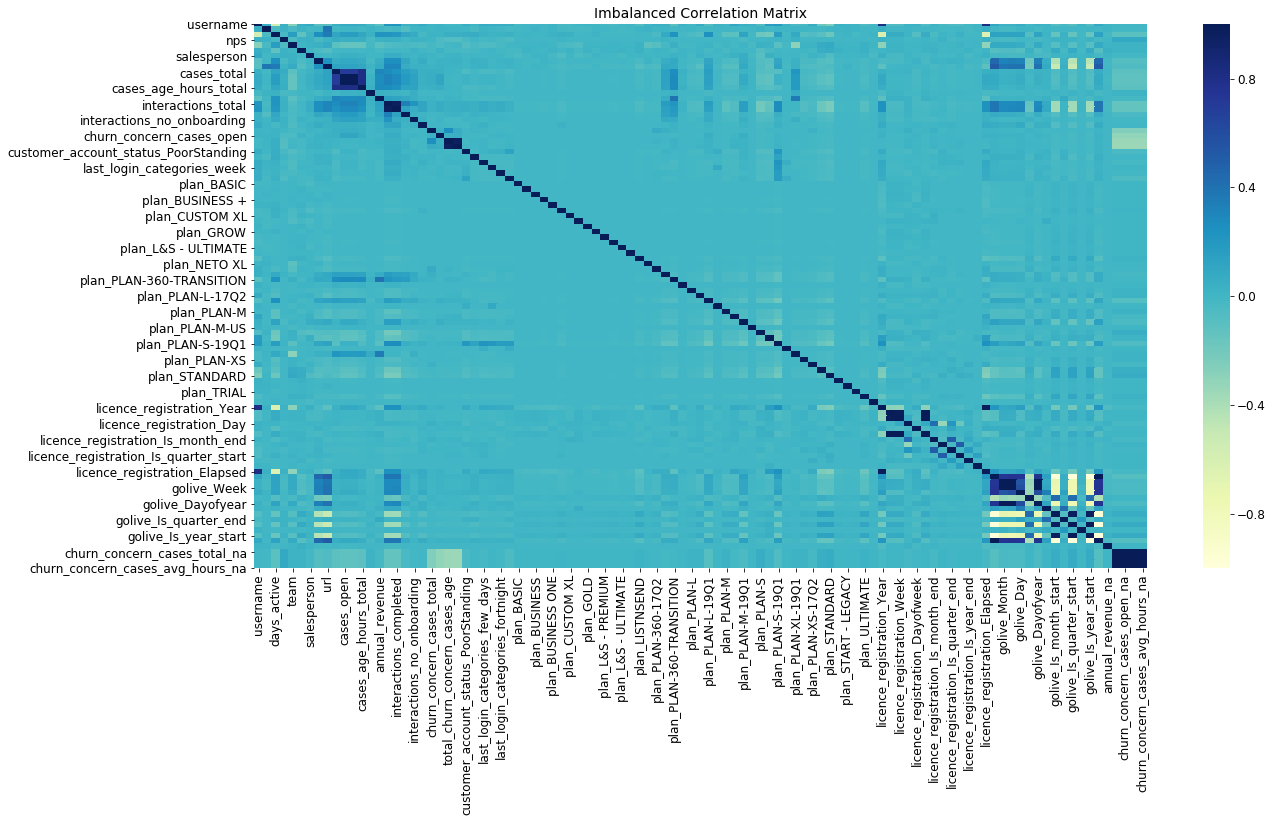

In [819]:
graph_corr(df_trn)

In [846]:
#data_summary(df_trn)

In [821]:
def split_vals(a,n): return a[:n], a[n:]

n_valid = 500
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

In [822]:
# Fix the dataset imbalance

sm = SMOTE(random_state=12, ratio = 1.0)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [848]:
# Tuning hyperparameters

tune = True

if tune:
    # Create the hyperparameter grid
    param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
                  #'min_samples_leaf': np.arange(1,3),
                  'n_estimators': np.arange(1,10),
                  #'class_weight':[{0: w} for w in [1, 2, 3, 5, 10, 20]],
                  'bootstrap': [True, False],
                  #'criterion': ['gini', 'entropy'],
                  #'max_depth': [None, 1, 2, 3]
                 }

    # Call GridSearchCV
    grid_search = GridSearchCV(RandomForestClassifier(), param_grid)

    # Fit the model
    %time grid_search.fit(X_valid, y_valid)

    print(grid_search.best_params_, grid_search.best_score_)

/Users/justinhennessy/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


CPU times: user 1.18 s, sys: 23.4 ms, total: 1.2 s
Wall time: 1.27 s
{'bootstrap': True, 'max_features': 'auto', 'n_estimators': 8} 0.876


/Users/justinhennessy/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [824]:
m = RandomForestClassifier(
    n_estimators=200,
    min_samples_leaf=2, 
    max_features='sqrt',
    n_jobs=-1, 
    #oob_score=True,
    max_depth=3,
    bootstrap=False,
    criterion='gini',
    #class_weight={0: 2, 1: 1}
    )

m.fit(X_train_res, y_train_res)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=3, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [825]:
# Change the threshold for the probability cutoff of a churn customer to 55%

validate_predictions = generate_predictions(X_valid)

In [826]:
uber_score(y_valid, validate_predictions)

[0.453125,
 0.7160493827160493,
 0.555023923444976,
 0.814,
 0.4448689174346975,
 0.186]

In [827]:
# Output the confusion matrix

conf_matrix(y_valid, validate_predictions)

[[349  70]
 [ 23  58]]


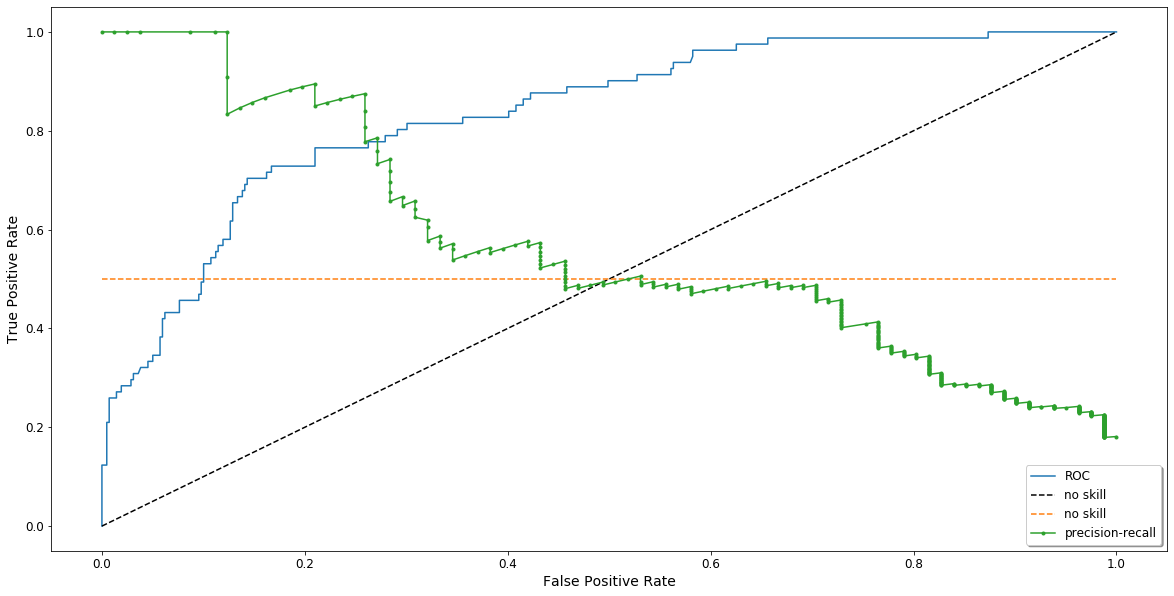

auc=0.571 ap=0.573


In [828]:
# Plot the ROC and precision-recall graphs
    
plot_roc_pr(m, X_valid, y_valid)

In [829]:
# Print the Area Under the Curve

area_under_curve = roc_auc_score(y_valid, y_pred_prob)
print('AUC: %.3f' % area_under_curve)

AUC: 0.828


In [830]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
15,interactions_total,0.134898
2,days_active,0.116033
16,interactions_completed,0.095460
10,cases_open,0.087557
9,cases_total,0.076846
12,cases_age_hours_total,0.075548
11,cases_closed,0.073853
60,plan_PLAN-S-19Q1,0.071873
14,annual_revenue,0.058236
7,golive_days,0.025253


In [831]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

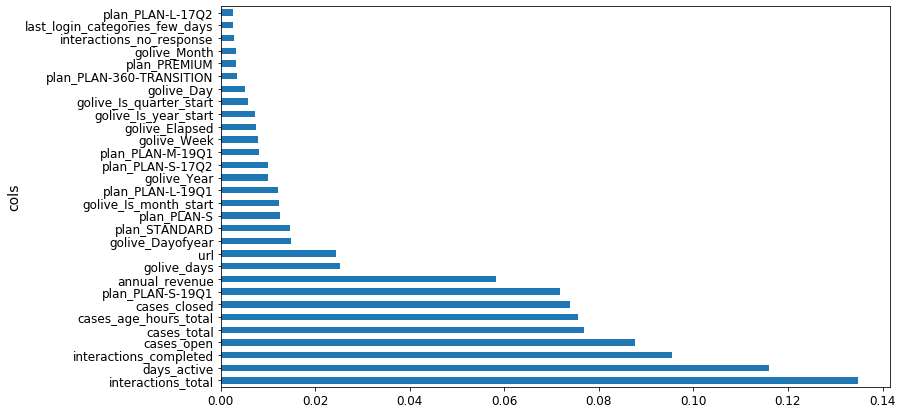

In [832]:
plot_fi(fi[:30]);

In [833]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

24

In [834]:
df_keep = df_trn[to_keep].copy()

In [835]:
X_train, X_valid = split_vals(df_keep, n_trn)

In [836]:
m_keep = RandomForestClassifier(
    n_estimators=200,
    min_samples_leaf=2, 
    max_features='sqrt',
    n_jobs=-1,
    max_depth=3,
    bootstrap=False,
    criterion='gini',
    #class_weight={0: 2, 1: 1}
    )

m_keep.fit(X_train, y_train)
print(uber_score(y_valid, validate_predictions))
conf_matrix(y_valid, validate_predictions)

[0.453125, 0.7160493827160493, 0.555023923444976, 0.814, 0.4448689174346975, 0.186]
[[349  70]
 [ 23  58]]


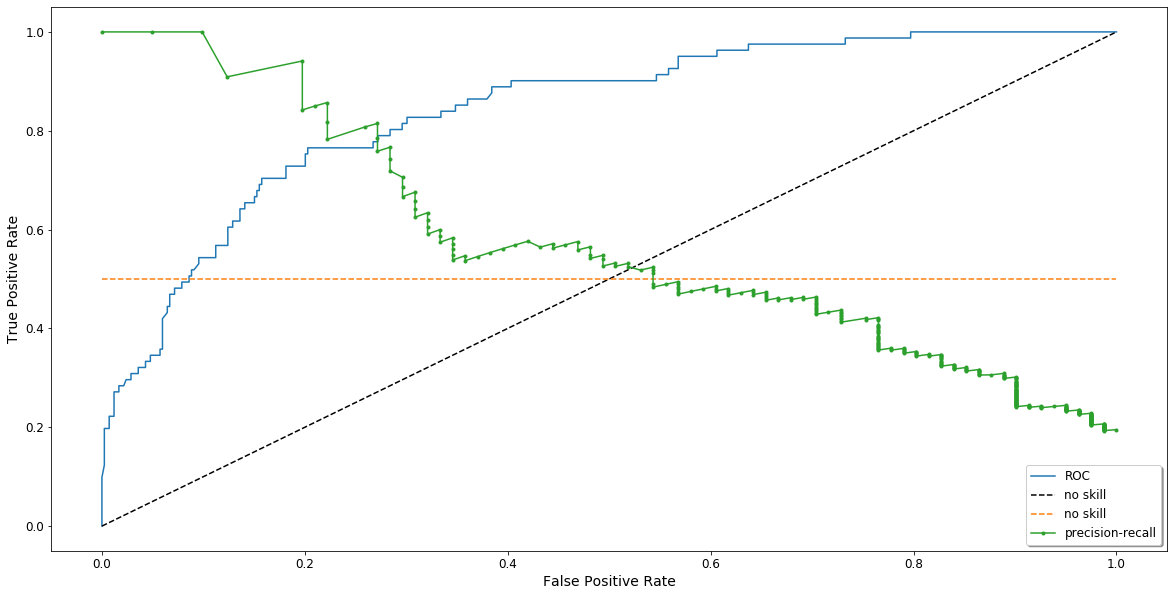

auc=0.578 ap=0.581


In [837]:
plot_roc_pr(m_keep, X_valid, y_valid)

In [838]:
from scipy.cluster import hierarchy as hc

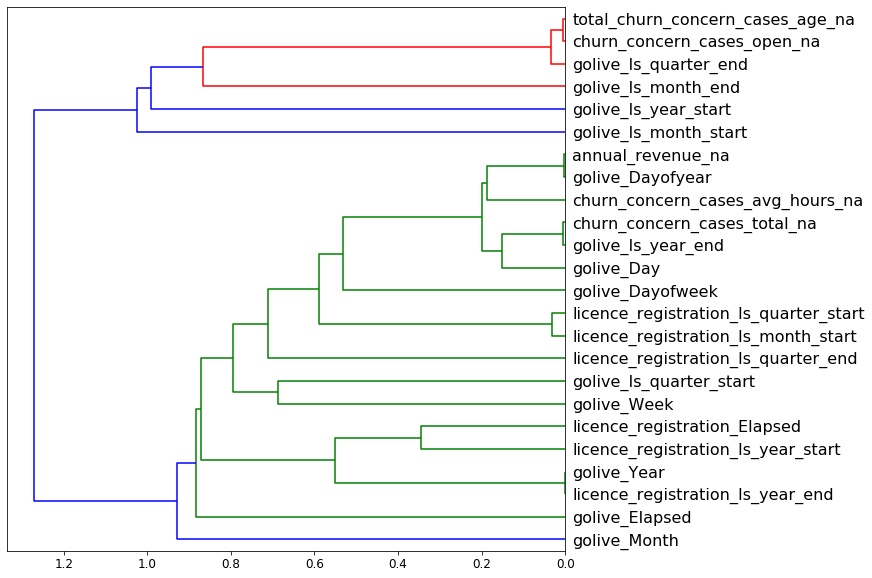

In [839]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(10,10))
dendrogram = hc.dendrogram(z, labels=df_trn.columns, orientation='left', leaf_font_size=16)
plt.show()

In [840]:
dataframe_data = []
for c in (df_trn):
    array = []
    array.append(c)
    array.extend(remove_columns_test(df_trn.drop(c, axis=1)))
    remove_columns_test(df_trn.drop(c, axis=1))
    dataframe_data.append(array)

In [841]:
# Create the pandas DataFrame
df_plot = pd.DataFrame(dataframe_data, columns = ['removed_column', 'precision', 'recall', 'f1_score', 'accuracy', 'kappa', 'mae'])

In [842]:
df_plot['column_code'] = df_plot.removed_column.astype("category").cat.codes

In [843]:
# Plot the impact of taking each feature out and retraining the model

import hvplot.pandas

df_plot.hvplot(x='column_code', y=['recall', 'f1_score', 'accuracy', 'kappa', 'mae'], kind='scatter')

:NdOverlay   [Variable]
   :Scatter   [column_code]   (value)

In [844]:
df_plot[df_plot.column_code.isin([29,89,42])]

,removed_column,precision,recall,f1_score,accuracy,kappa,mae,column_code
16,interactions_completed,0.978652,0.772127,0.863208,0.862498,0.728801,0.137502,29
65,plan_PREMIUM,0.942595,0.813408,0.873249,0.867322,0.735634,0.132678,89
84,licence_registration_Elapsed,0.955622,0.839168,0.893617,0.887734,0.775834,0.112266,42
